<a href="https://colab.research.google.com/github/DrakeData/Bankruptcy_Prediction/blob/main/bankruptcy_pred_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4: Company Bankruptcy Prediction

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import f1_score

## Ingest
Donwloading the data from Kaggle's API

In [2]:
! pip install kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp './drive/MyDrive/Colab Notebooks/API Keys/kaggle.json' ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download fedesoriano/company-bankruptcy-prediction

  0% 0.00/4.63M [00:00<?, ?B/s]
100% 4.63M/4.63M [00:00<00:00, 59.1MB/s]


In [7]:
! unzip company-bankruptcy-prediction

Archive:  company-bankruptcy-prediction.zip
  inflating: data.csv                


### Import Data

In [8]:
df = pd.read_csv('/content/data.csv')
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.264184,0.368913,0.011543,0.005348,0.629631,0.021248,0.207516,0.792484,0.005100,..

## EDA

In [9]:
df.shape

(6819, 96)

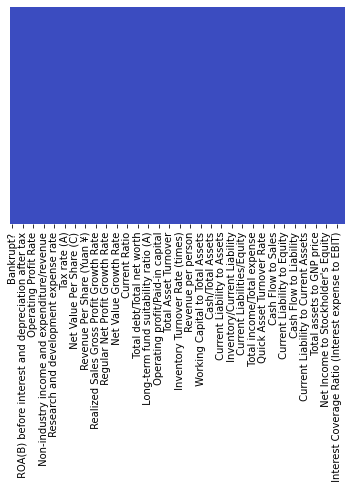

In [10]:
# Heatmap check for nulls in train set
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='coolwarm');

In [11]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [12]:
# Check for duplicates
print(f'Number of duplicates values : {df.duplicated().sum()}')

Number of duplicates values : 0


In [13]:
# Check bankrupt (Y/N) column
df['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

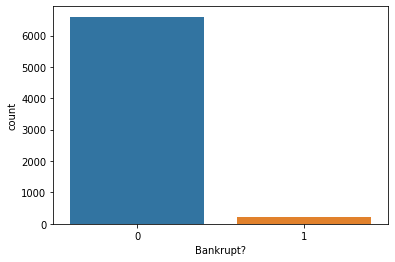

In [14]:
sns.countplot(x='Bankrupt?', data=df);

Looks like there are a high amount of 'No' compared to 'Yes' in the 'Bankrupt?' column, which means that this data set is highly unbalanced.

### Rebalence data

In [15]:
# Separate majority and minority classes
df_majority = df[df['Bankrupt?']==0]
df_minority = df[df['Bankrupt?']==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=6599,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled['Bankrupt?'].value_counts()

0    6599
1    6599
Name: Bankrupt?, dtype: int64

In [16]:
df_upsampled.shape

(13198, 96)

### Check for outliers

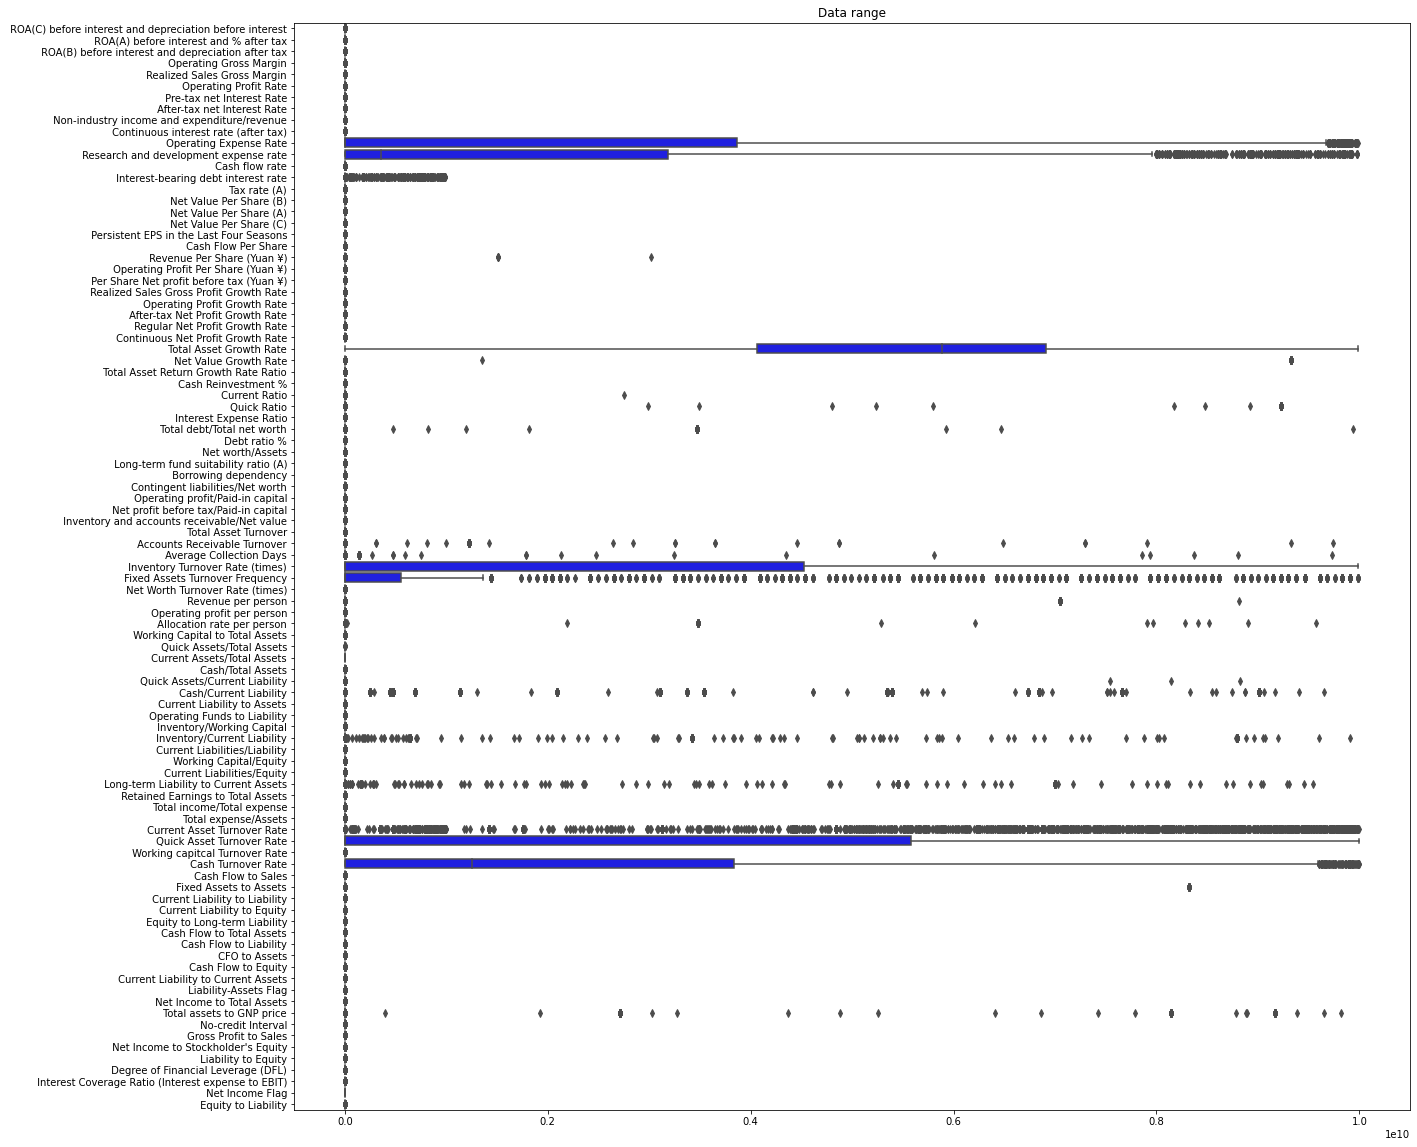

In [17]:
plt.figure(figsize=(20,20))
sns.boxplot(data=df_upsampled.drop(['Bankrupt?'], axis=1), orient='h', color='blue')
plt.title('Data range')
plt.show()

Code caps the numeric columns by looking at the quantile values between .01 and .99 and replaces the value to the closest quantile in the range.

In [18]:
pd.options.mode.chained_assignment = None  # default='warn'

def cap_data(df):
    for col in df.columns:
        print("capping the ",col)
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            percentiles = df[col].quantile([0.01,0.99]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df

final_df = cap_data(df_upsampled)

capping the  Bankrupt?
capping the   ROA(C) before interest and depreciation before interest
capping the   ROA(A) before interest and % after tax
capping the   ROA(B) before interest and depreciation after tax
capping the   Operating Gross Margin
capping the   Realized Sales Gross Margin
capping the   Operating Profit Rate
capping the   Pre-tax net Interest Rate
capping the   After-tax net Interest Rate
capping the   Non-industry income and expenditure/revenue
capping the   Continuous interest rate (after tax)
capping the   Operating Expense Rate
capping the   Research and development expense rate
capping the   Cash flow rate
capping the   Interest-bearing debt interest rate
capping the   Tax rate (A)
capping the   Net Value Per Share (B)
capping the   Net Value Per Share (A)
capping the   Net Value Per Share (C)
capping the   Persistent EPS in the Last Four Seasons
capping the   Cash Flow Per Share
capping the   Revenue Per Share (Yuan ¥)
capping the   Operating Profit Per Share (Yuan

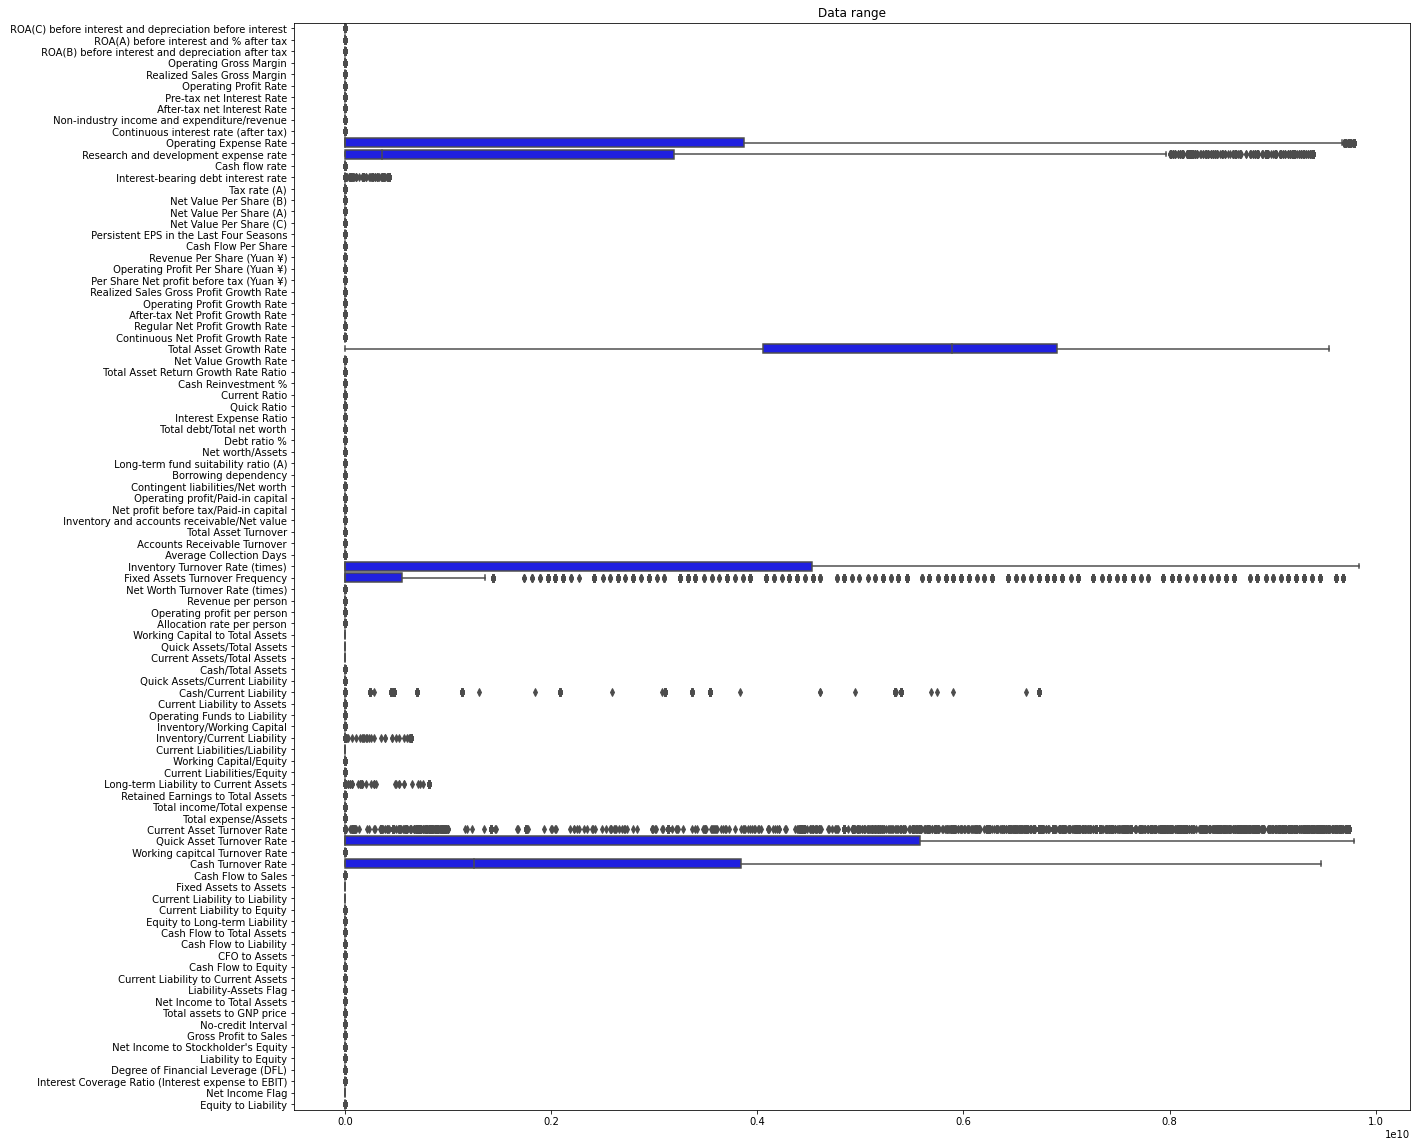

In [19]:
plt.figure(figsize=(20,20))
sns.boxplot(data=final_df.drop(['Bankrupt?'], axis=1), orient='h', color='blue')
plt.title('Data range')
plt.show()

## Modeling
From the viewpoint of a savvy investor, my objective would be to build a model that can accurately determine that a business will not file for bankruptcy. For this, we would want to compare the precision score for 0s and verify which model has the highest score.

In [20]:
# defining dependent and independent variables
x = final_df.drop('Bankrupt?', axis=1)
y = final_df['Bankrupt?']

In [21]:
# split data into 80% train & 20% test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                    random_state=0)

### Support Vector Machine (SVM) Model

In [22]:
# Set up model
svc = SVC(kernel='rbf', probability=True)
svc.fit(x_train, y_train)

# Get confusion matrix
y_pred = svc.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(f'Confusion matrix:\n {cm}')

Confusion matrix:
 [[ 934  334]
 [ 251 1121]]


In [23]:
# Check accuracy
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy score = {acc}')
print(f'Classification Report {classification_report(y_test, y_pred)}')

Accuracy score = 0.7784090909090909
Classification Report               precision    recall  f1-score   support

           0       0.79      0.74      0.76      1268
           1       0.77      0.82      0.79      1372

    accuracy                           0.78      2640
   macro avg       0.78      0.78      0.78      2640
weighted avg       0.78      0.78      0.78      2640



Looking at the classification report, the SVM was able to accurately predict 79% of no (0) bankruptcies and 77% yes (1) bankruptcies (seen in the precision column). The overall accuracy of this classification model is around 77.8%.

In [24]:
svc_probs = svc.predict_proba(x_test)
svc_auc = roc_auc_score(y_test, svc_probs[:, 1])
print('Prediction: AUROC = %.3f' % (svc_auc))

Prediction: AUROC = 0.856


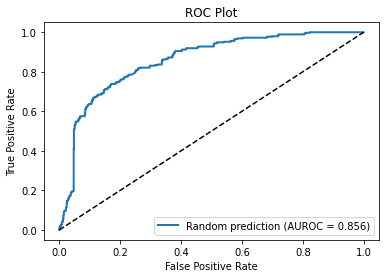

In [25]:
svc_fpr, svc_tpr, _ = roc_curve(y_test, svc_probs[:, 1])

plt.plot(svc_fpr, svc_tpr, linewidth=2, label='Random prediction (AUROC = %0.3f)' % svc_auc)
plt.plot([0,1], [0,1], 'k--')

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

#### Tuning the SVM Model
To try and enhance our SVM model, I will see what changing the kernel type from Radial-basis function (rbf) to the poly algorithm. See [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) for other kernel options for future review.

In [26]:
# Set up model
svc2 = SVC(kernel='poly', probability=True)
svc2.fit(x_train, y_train)

# Get confusion matrix
y_pred2 = svc2.predict(x_test)
cm2 = confusion_matrix(y_test, y_pred2)
print(f'Confusion matrix:\n {cm2}')

Confusion matrix:
 [[ 787  481]
 [ 260 1112]]


In [27]:
# Check accuracy
acc2 = accuracy_score(y_test, y_pred2)
print(f'Accuracy score = {acc2}')
print(f'Classification Report {classification_report(y_test, y_pred2)}')

Accuracy score = 0.7193181818181819
Classification Report               precision    recall  f1-score   support

           0       0.75      0.62      0.68      1268
           1       0.70      0.81      0.75      1372

    accuracy                           0.72      2640
   macro avg       0.72      0.72      0.71      2640
weighted avg       0.72      0.72      0.72      2640



Compared to the first SVC model, we can already identify that the second model is performing less. The precision is lower with lower recall, which indicates that the model is not classifying the proper values as accurately.

In [28]:
svc_probs2 = svc2.predict_proba(x_test)
svc_auc2 = roc_auc_score(y_test, svc_probs2[:, 1])
print('Prediction: AUROC = %.3f' % (svc_auc2))

Prediction: AUROC = 0.794


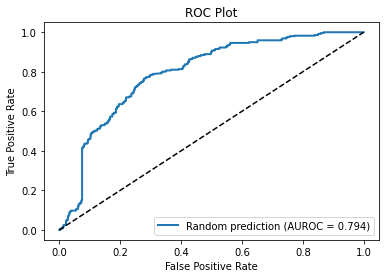

In [29]:
svc_fpr2, svc_tpr2, _ = roc_curve(y_test, svc_probs2[:, 1])

plt.plot(svc_fpr2, svc_tpr2, linewidth=2, label='Random prediction (AUROC = %0.3f)' % svc_auc2)
plt.plot([0,1], [0,1], 'k--')

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

#### Testing SVM Regularization Parameter
From [sklearn's documentatoin](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html): The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty. Default = 1.0

In [30]:
# Set up model
svc3 = SVC(kernel='rbf', C=2, probability=True)
svc3.fit(x_train, y_train)

# Get confusion matrix
y_pred3 = svc3.predict(x_test)
cm3 = confusion_matrix(y_test, y_pred3)
print(f'Confusion matrix:\n {cm3}')

Confusion matrix:
 [[ 956  312]
 [ 226 1146]]


In [31]:
# Check accuracy
acc3 = accuracy_score(y_test, y_pred3)
print(f'Accuracy score = {acc3}')
print(f'Classification Report {classification_report(y_test, y_pred3)}')

Accuracy score = 0.7962121212121213
Classification Report               precision    recall  f1-score   support

           0       0.81      0.75      0.78      1268
           1       0.79      0.84      0.81      1372

    accuracy                           0.80      2640
   macro avg       0.80      0.79      0.80      2640
weighted avg       0.80      0.80      0.80      2640



The precision and recall score improved from the first SVM model by a couple points; it is much better than the second SVM model. The precision score for 0s is 81%, which is pretty good for our objective.

In [32]:
svc3_probs = svc3.predict_proba(x_test)
svc3_auc = roc_auc_score(y_test, svc3_probs[:, 1])
print('Prediction: AUROC = %.3f' % (svc3_auc))

Prediction: AUROC = 0.876


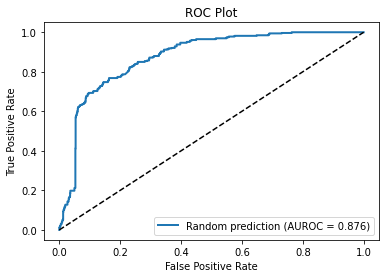

In [33]:
svc_fpr3, svc_tpr3, _ = roc_curve(y_test, svc3_probs[:, 1])

plt.plot(svc_fpr3, svc_tpr3, linewidth=2, label='Random prediction (AUROC = %0.3f)' % svc3_auc)
plt.plot([0,1], [0,1], 'k--')

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

### Logistic Regression Model

In [34]:
# Set up model
log_regre = LogisticRegression(max_iter=1000)
log_regre.fit(x_train,y_train)

# Get confusion matrix
y_pred4 = log_regre.predict(x_test)
lr_auc = roc_auc_score(y_test, y_pred4)
cm4 = confusion_matrix(y_test, y_pred4)
print(f'Confusion matrix:\n {cm4}')

Confusion matrix:
 [[944 324]
 [709 663]]


In [35]:
# Check accuracy
acc2 = accuracy_score(y_test, y_pred4)
print(f'Accuracy score = {acc2}')
print(f'Classification Report {classification_report(y_test, y_pred4)}')

Accuracy score = 0.6087121212121213
Classification Report               precision    recall  f1-score   support

           0       0.57      0.74      0.65      1268
           1       0.67      0.48      0.56      1372

    accuracy                           0.61      2640
   macro avg       0.62      0.61      0.60      2640
weighted avg       0.62      0.61      0.60      2640



Looking at the classification report, the Logistic Regression Model was able to accurately predict 57% of no (0) bankruptcies and 67% yes (1) bankruptcies (seen in the precision column). The overall accuracy of this classification model is around 60.9%. For our objective, the 0s precision score is low and I wouldn't feel comfortable using it as an investor.

In [36]:
lr_probs = svc.predict_proba(x_test)
lr_auc = roc_auc_score(y_test, lr_probs[:, 1])
print('Prediction: AUROC = %.3f' % (lr_auc))

Prediction: AUROC = 0.856


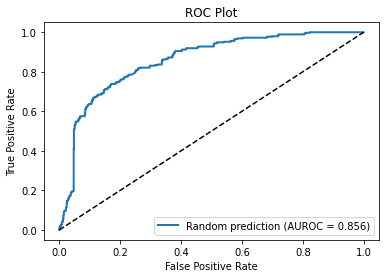

In [37]:
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs[:, 1])

plt.plot(lr_fpr, lr_tpr,  linewidth=2, label='Random prediction (AUROC = %0.3f)' % lr_auc)
plt.plot([0,1], [0,1], 'k--')

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

### Naive Bayes Model

In [38]:
# Set up model
nb = GaussianNB()
nb.fit(x_train, y_train)

# Get confusion matrix
y_pred3 = nb.predict(x_test)
cm = confusion_matrix(y_test, y_pred3)
print(f'Confusion matrix:\n {cm}')

Confusion matrix:
 [[1021  247]
 [ 775  597]]


In [39]:
# Check accuracy
acc3 = accuracy_score(y_test, y_pred3)
print(f'Accuracy score = {acc3}')
print(f'Classification Report {classification_report(y_test, y_pred3)}')

Accuracy score = 0.6128787878787879
Classification Report               precision    recall  f1-score   support

           0       0.57      0.81      0.67      1268
           1       0.71      0.44      0.54      1372

    accuracy                           0.61      2640
   macro avg       0.64      0.62      0.60      2640
weighted avg       0.64      0.61      0.60      2640



Similar to the Logistic Regression Model, the Naive Bayes Model has a lower precision score for 0s (57%). The model is better at predicting 1s though, which is if a company will go bankrupt. This could be important to investors, but it strays away from the main objective.

In [40]:
nb_probs = nb.predict_proba(x_test)
nb_auc = roc_auc_score(y_test, nb_probs[:, 1])
print('Prediction: AUROC = %.3f' % (nb_auc))

Prediction: AUROC = 0.707


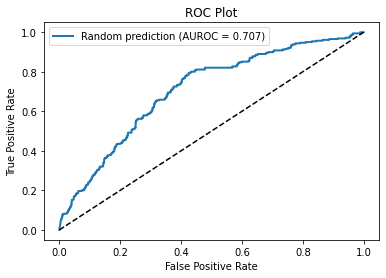

In [41]:
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs[:,1])

plt.plot(nb_fpr, nb_tpr, linewidth=2, label='Random prediction (AUROC = %0.3f)' % nb_auc)
plt.plot([0,1], [0,1], 'k--')

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

## Conclusion
After performing an EDA, I was able to identify that the data set had several outliers and was unbalanced. These were addressed so that the noise can be limited in the data and passed through several different types of models. After analyzing the precision, recall, and accuracy scores, the model the performed the best was the SMV3 model where I tuned the C score to 2. Clarifying the C score helps the model avoid misclassifying variables, which improves overall accuracy. The precision score for 0s was also the highest out of all the models at 81%, which lines up with the objective to predict companies that will not file for bankruptcy.

# Assignment 5: Company Bankruptcy Prediction (Continued)
This section we will be using Random Forest Classifier, Gradient Boosted Trees, and Extra Trees to try and predict company bankruptcy.

In [49]:
# defining dependent and independent variables
x = final_df.drop('Bankrupt?', axis=1)
y = final_df['Bankrupt?']

# split data into 80% train & 20% test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                    random_state=0)

## EDA

In [56]:
x_train.describe()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,1.055800e+04,1.055800e+04,10558.000000,1.055800e+04,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,1.055800e+04,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,...,10558.000000,10558.000000,10558.000000,1.055800e+04,10558.000000,10558.000000,10558.000000,1.055800e+04,10558.000000,10558.000000,10558.000000,1.055800e+04,10558.000000,10558.000000,10558.000000,1.055800e+04,1.055800e+04,10558.000000,1.055800e+04,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.000000,10558.0,10558.000000
mean,0.463967,0.509289,0.509680,0.603672,0.603684,0.998894,0.797126,0.809055,0.303272,0.781322,1.944874e+09,1.806177e+09,0.464261,6.517143e+06,0.072202,0.175769,0.175725,0.175817,0.209432,0.320049,0.032876,0.098560,0.166511,0.022180,0.847901,0.688460,0.688508,0.217497,5.163754e+09,0.000443,0.263762,0.376511,0.010806,0.007702,0.630771,0.018749,0.147927,0.852073,0.007078,0.380094,...,0.497415,0.086099,0.008138,1.266912e+08,0.115804,0.346781,0.277327,8.098930e+06,0.750059,0.733436,0.335157,9.172542e+06,0.920307,0.002238,0.038891,1.286449e+09,2.395028e+09,0.593964,2.342260e+09,0.671567,0.285426,0.750059,0.335157,0.119250,0.642068,0.459345,0.575995,0.313446,0.043859,0.014018,0.773889,0.012909,0.623571,0.603670,0.836177,0.284253,0.027239,0.

Column name:  ROA(C) before interest and depreciation before interest 
 Min: 0.19571539999024987 
 Max: 0.6380860917466976


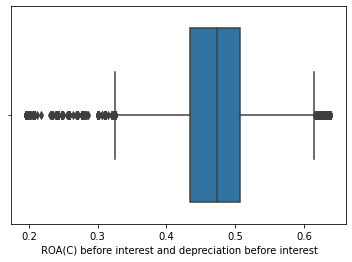

Column name:  ROA(A) before interest and % after tax 
 Min: 0.10662887047536 
 Max: 0.6942340819886609


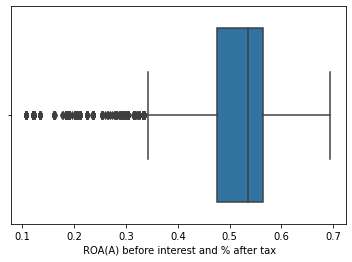

Column name:  ROA(B) before interest and depreciation after tax 
 Min: 0.1828534718132662 
 Max: 0.6864034477220406


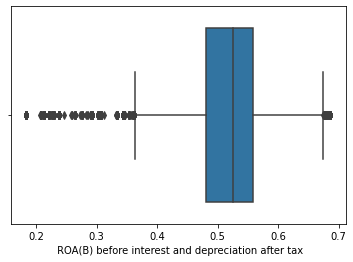

Column name:  Operating Gross Margin 
 Min: 0.550281785554707 
 Max: 0.6477880914974269


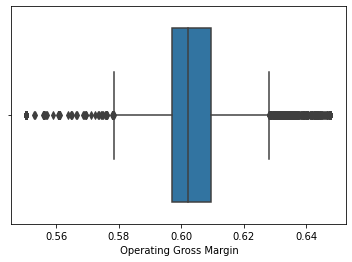

Column name:  Realized Sales Gross Margin 
 Min: 0.550281785554707 
 Max: 0.6477880914974269


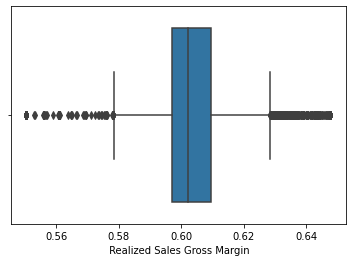

Column name:  Operating Profit Rate 
 Min: 0.996294747107564 
 Max: 0.9993446438661182


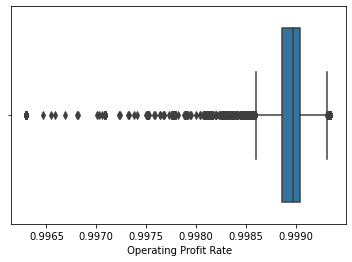

Column name:  Pre-tax net Interest Rate 
 Min: 0.790786884715219 
 Max: 0.7979767236633999


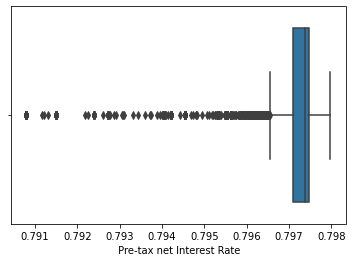

Column name:  After-tax net Interest Rate 
 Min: 0.802967405875129 
 Max: 0.8098079784414024


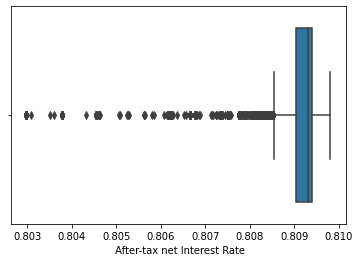

Column name:  Non-industry income and expenditure/revenue 
 Min: 0.298238329145094 
 Max: 0.30438716395089765


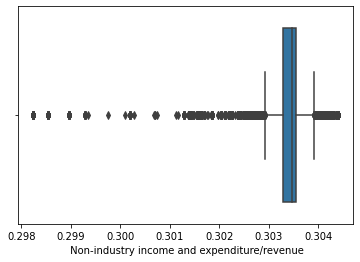

Column name:  Continuous interest rate (after tax) 
 Min: 0.775601538361781 
 Max: 0.7820854971984489


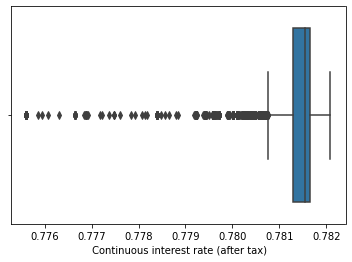

Column name:  Operating Expense Rate 
 Min: 0.0001025695700947 
 Max: 9790000000.0


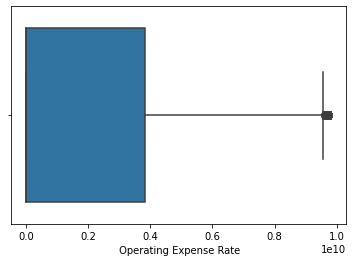

Column name:  Research and development expense rate 
 Min: 0.0 
 Max: 9390000000.0


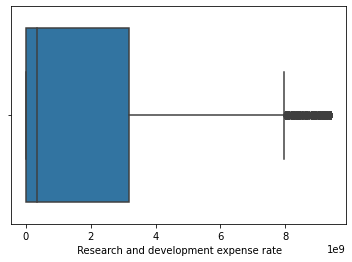

Column name:  Cash flow rate 
 Min: 0.4362147572196637 
 Max: 0.5045440896471315


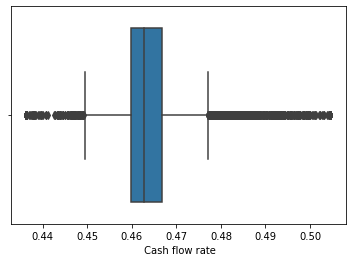

Column name:  Interest-bearing debt interest rate 
 Min: 0.0 
 Max: 430000000.0


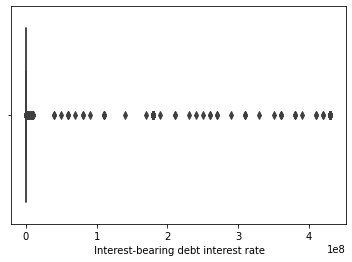

Column name:  Tax rate (A) 
 Min: 0.0 
 Max: 0.564328373317137


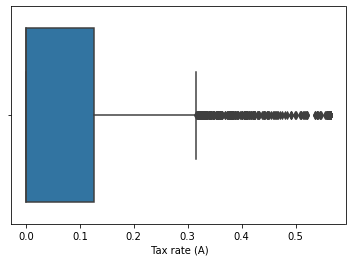

Column name:  Net Value Per Share (B) 
 Min: 0.120180354810164 
 Max: 0.28476086132063627


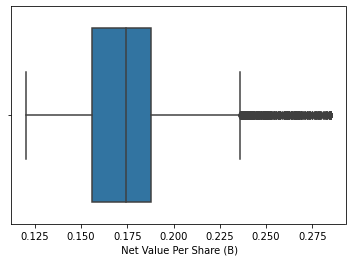

Column name:  Net Value Per Share (A) 
 Min: 0.120011798912814 
 Max: 0.28476086132063627


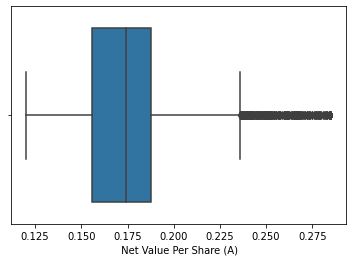

Column name:  Net Value Per Share (C) 
 Min: 0.120011798912814 
 Max: 0.28476086132063627


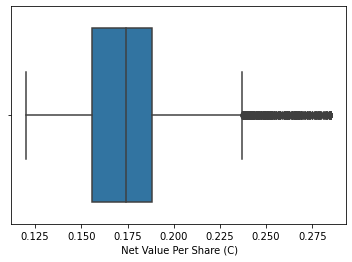

Column name:  Persistent EPS in the Last Four Seasons 
 Min: 0.10182471400208 
 Max: 0.3090753521792574


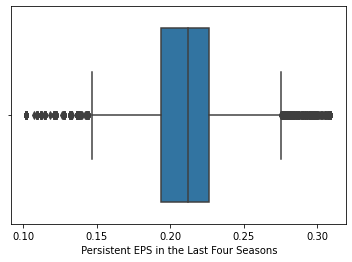

Column name:  Cash Flow Per Share 
 Min: 0.2802521751432416 
 Max: 0.35626794935276207


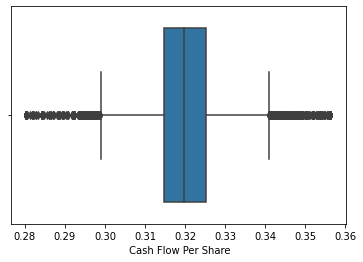

Column name:  Revenue Per Share (Yuan ¥) 
 Min: 0.0007411104557073 
 Max: 0.2220338188363054


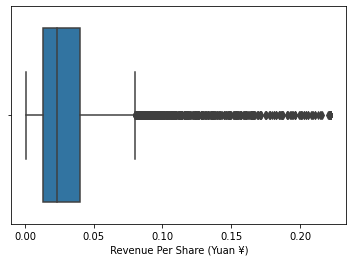

Column name:  Operating Profit Per Share (Yuan ¥) 
 Min: 0.0407947235567136 
 Max: 0.17882012865401847


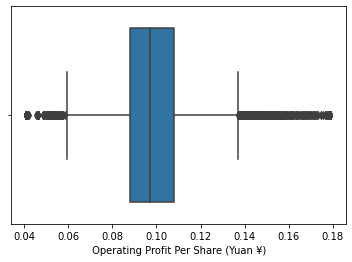

Column name:  Per Share Net profit before tax (Yuan ¥) 
 Min: 0.0761467198915418 
 Max: 0.26437598855163047


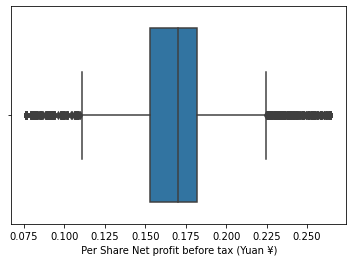

Column name:  Realized Sales Gross Profit Growth Rate 
 Min: 0.0204586647032095 
 Max: 0.030031976397299612


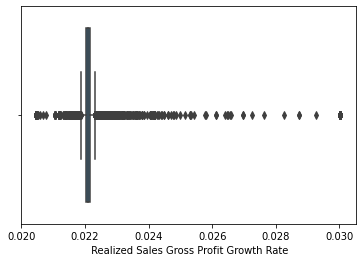

Column name:  Operating Profit Growth Rate 
 Min: 0.839645289321501 
 Max: 0.8508117414373548


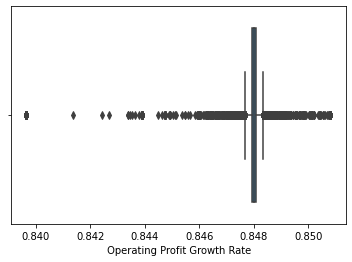

Column name:  After-tax Net Profit Growth Rate 
 Min: 0.656620936898182 
 Max: 0.6927704221814882


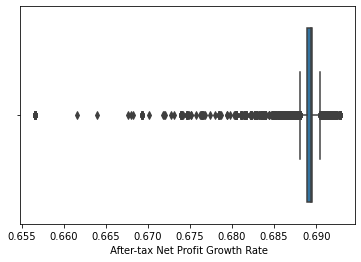

Column name:  Regular Net Profit Growth Rate 
 Min: 0.656620936898182 
 Max: 0.6941754185932332


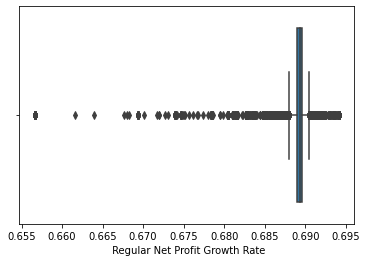

Column name:  Continuous Net Profit Growth Rate 
 Min: 0.214113158859308 
 Max: 0.21808308211150554


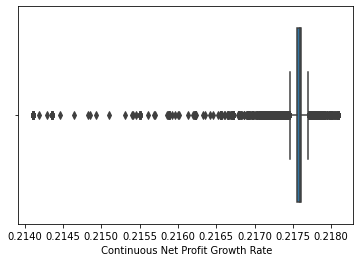

Column name:  Total Asset Growth Rate 
 Min: 0.00010326718980221301 
 Max: 9550000000.0


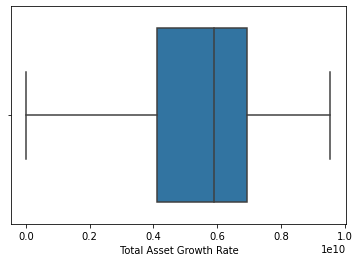

Column name:  Net Value Growth Rate 
 Min: 0.0001670196796745 
 Max: 0.0010147177951345355


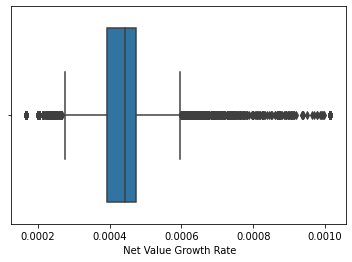

Column name:  Total Asset Return Growth Rate Ratio 
 Min: 0.259021221375232 
 Max: 0.26661273904157995


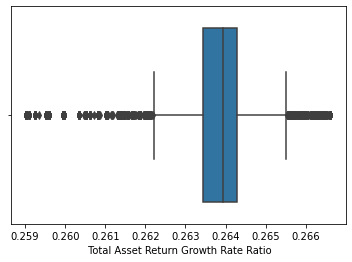

Column name:  Cash Reinvestment % 
 Min: 0.295896389851347 
 Max: 0.439868112216385


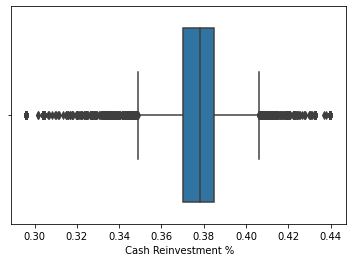

Column name:  Current Ratio 
 Min: 0.0010864240673196 
 Max: 0.06892071475596072


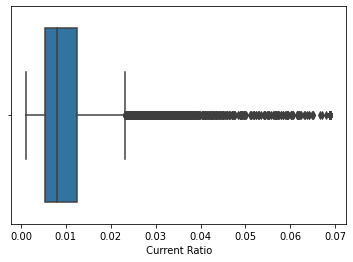

Column name:  Quick Ratio 
 Min: 0.00022813844766032598 
 Max: 0.0730055509322048


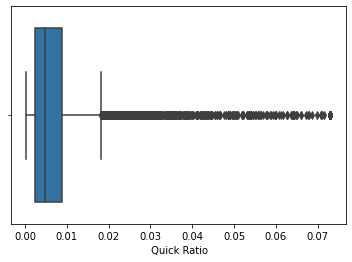

Column name:  Interest Expense Ratio 
 Min: 0.617486746756894 
 Max: 0.646975041437789


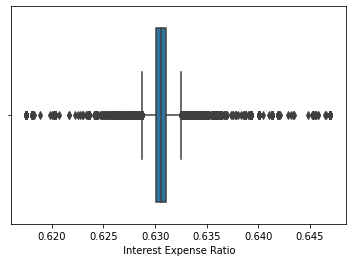

Column name:  Total debt/Total net worth 
 Min: 0.0006298343045258331 
 Max: 0.378620085902662


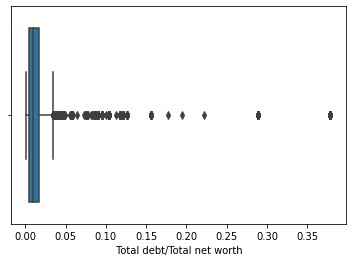

Column name:  Debt ratio % 
 Min: 0.0168092632342715 
 Max: 0.326934123409015


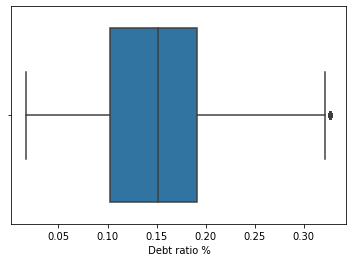

Column name:  Net worth/Assets 
 Min: 0.673065876590985 
 Max: 0.983190736765728


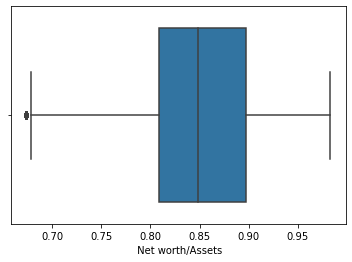

Column name:  Long-term fund suitability ratio (A) 
 Min: 0.0046759019526102 
 Max: 0.0528214852224774


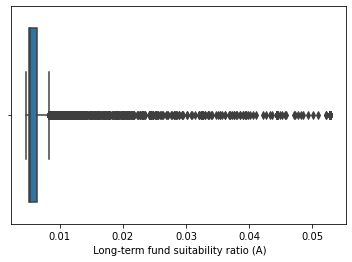

Column name:  Borrowing dependency 
 Min: 0.29589360364854 
 Max: 0.528356032325094


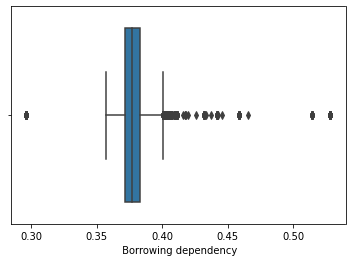

Column name:  Contingent liabilities/Net worth 
 Min: 0.0053658477137564 
 Max: 0.013776353953397786


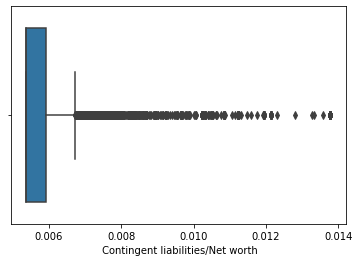

Column name:  Operating profit/Paid-in capital 
 Min: 0.0408096796782126 
 Max: 0.17697192502483455


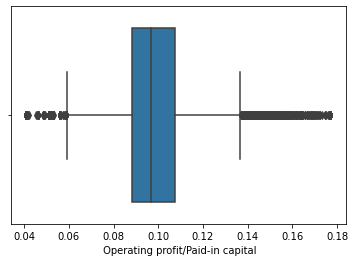

Column name:  Net profit before tax/Paid-in capital 
 Min: 0.0792775808762537 
 Max: 0.25761202020963747


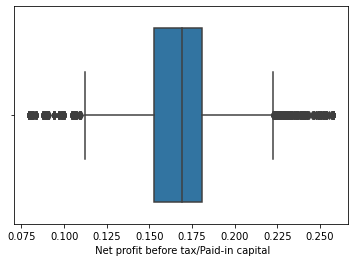

Column name:  Inventory and accounts receivable/Net value 
 Min: 0.390738227519784 
 Max: 0.471816918824849


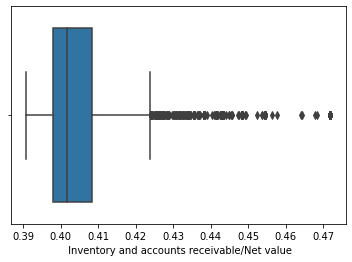

Column name:  Total Asset Turnover 
 Min: 0.0044977511244377 
 Max: 0.47376311844078


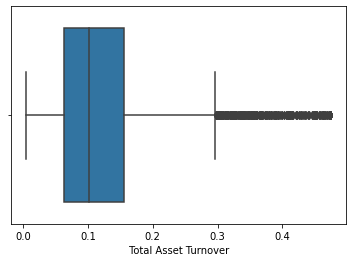

Column name:  Accounts Receivable Turnover 
 Min: 0.0002353585667474 
 Max: 0.028516084526188964


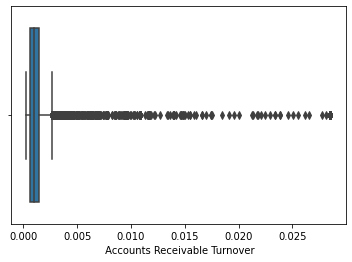

Column name:  Average Collection Days 
 Min: 0.0005413782944875 
 Max: 0.0391056157324191


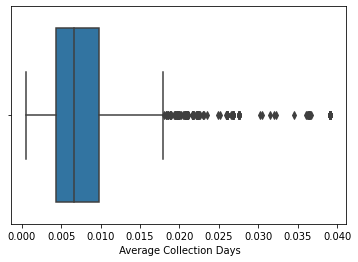

Column name:  Inventory Turnover Rate (times) 
 Min: 0.0001016508518704 
 Max: 9840000000.0


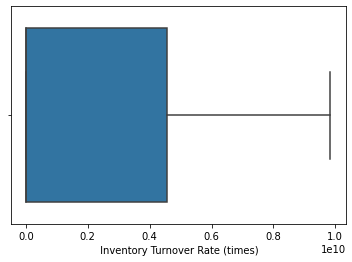

Column name:  Fixed Assets Turnover Frequency 
 Min: 0.0001051531870115 
 Max: 9680000000.0


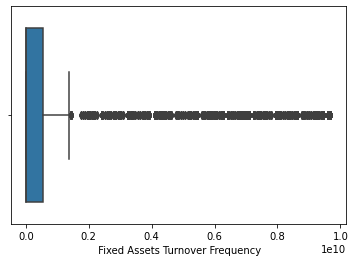

Column name:  Net Worth Turnover Rate (times) 
 Min: 0.01 
 Max: 0.20532741935483856


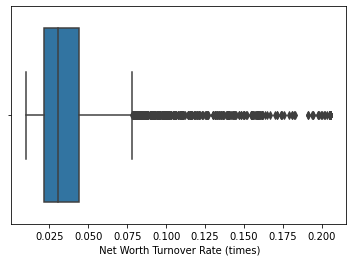

Column name:  Revenue per person 
 Min: 0.002128783984254433 
 Max: 0.291699836963706


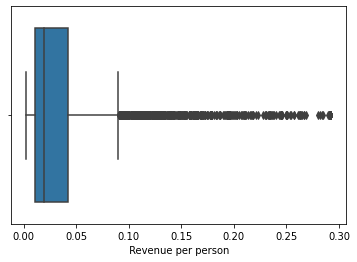

Column name:  Operating profit per person 
 Min: 0.323669749666448 
 Max: 0.4806100042966014


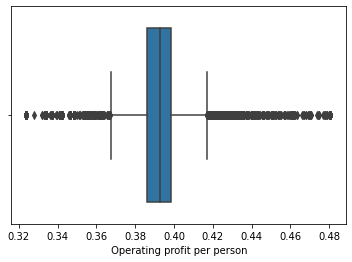

Column name:  Allocation rate per person 
 Min: 0.00025511667640190004 
 Max: 0.296806512745454


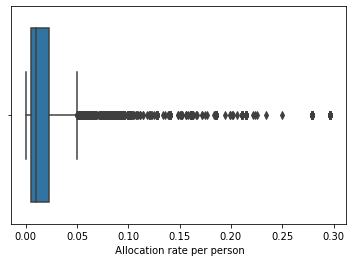

Column name:  Working Capital to Total Assets 
 Min: 0.643090941988889 
 Max: 0.9463073218810073


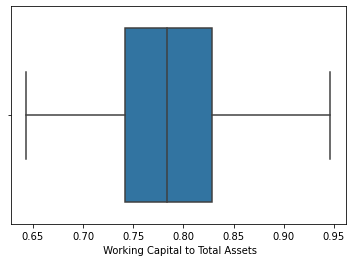

Column name:  Quick Assets/Total Assets 
 Min: 0.0261772727998836 
 Max: 0.8341125716146113


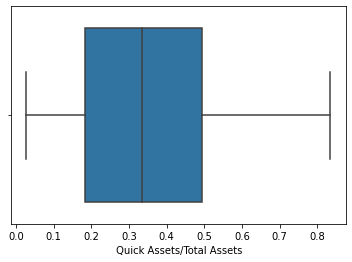

Column name:  Current Assets/Total Assets 
 Min: 0.0715709910663357 
 Max: 0.9548786611951657


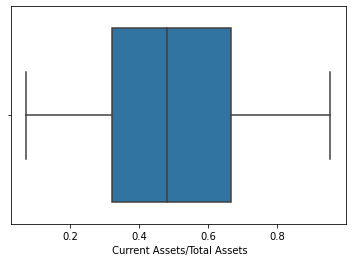

Column name:  Cash/Total Assets 
 Min: 0.0008906952577058 
 Max: 0.588536302869117


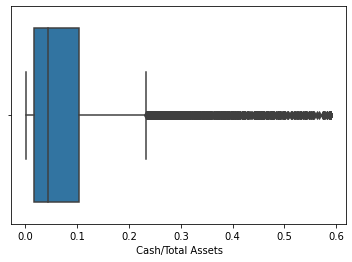

Column name:  Quick Assets/Current Liability 
 Min: 0.0002532363167652 
 Max: 0.06252393901280427


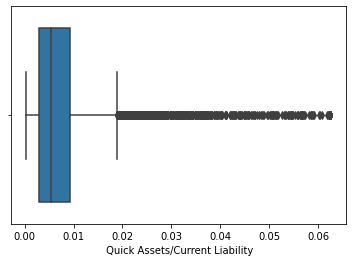

Column name:  Cash/Current Liability 
 Min: 0.000119052110288527 
 Max: 6730000000.0


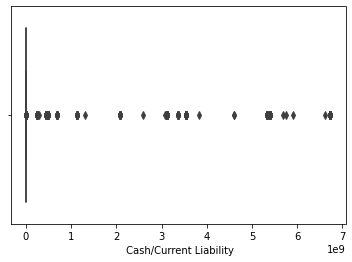

Column name:  Current Liability to Assets 
 Min: 0.014124325464950124 
 Max: 0.302764902032466


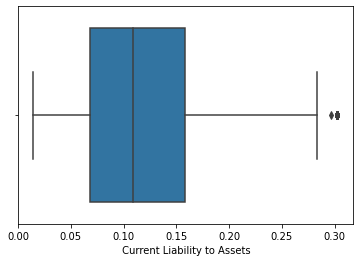

Column name:  Operating Funds to Liability 
 Min: 0.273004260387001 
 Max: 0.4483133656030155


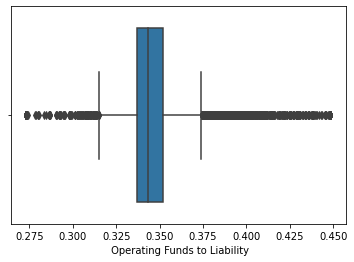

Column name:  Inventory/Working Capital 
 Min: 0.267393652362703 
 Max: 0.2882173370090313


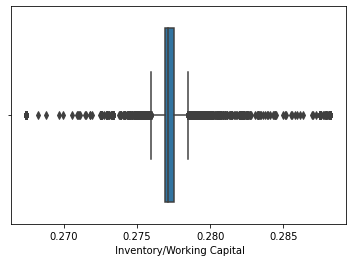

Column name:  Inventory/Current Liability 
 Min: 0.0 
 Max: 644000000.0


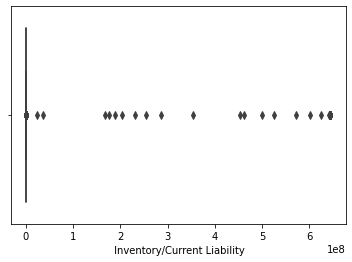

Column name:  Current Liabilities/Liability 
 Min: 0.22149488967886866 
 Max: 1.0


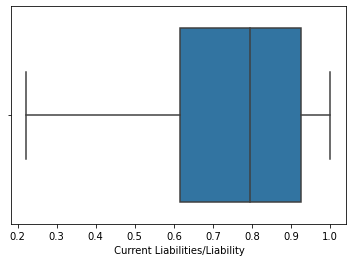

Column name:  Working Capital/Equity 
 Min: 0.676961240545963 
 Max: 0.749178726114564


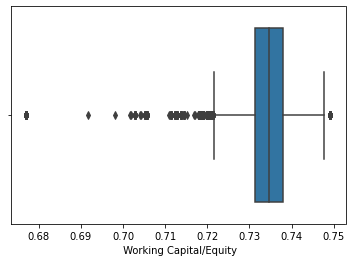

Column name:  Current Liabilities/Equity 
 Min: 0.294906403882351 
 Max: 0.437794256884166


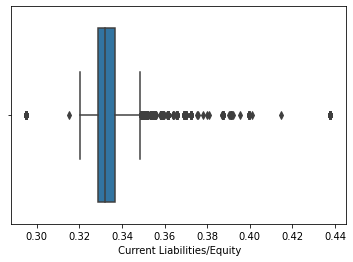

Column name:  Long-term Liability to Current Assets 
 Min: 0.0 
 Max: 813180000.0000039


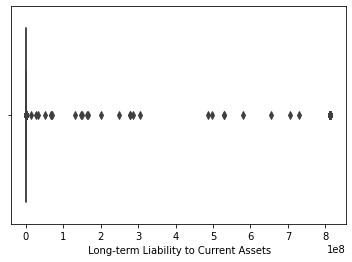

Column name:  Retained Earnings to Total Assets 
 Min: 0.7776365884871499 
 Max: 0.9656437770180677


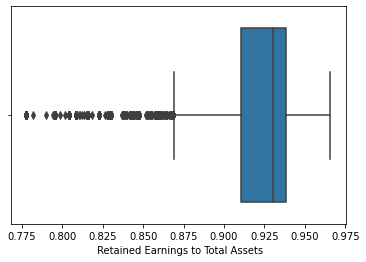

Column name:  Total income/Total expense 
 Min: 0.0017098117016369082 
 Max: 0.0033332810393116165


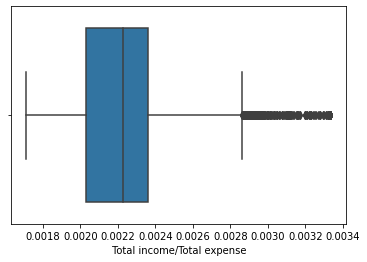

Column name:  Total expense/Assets 
 Min: 0.0048261005867615 
 Max: 0.20530782114416


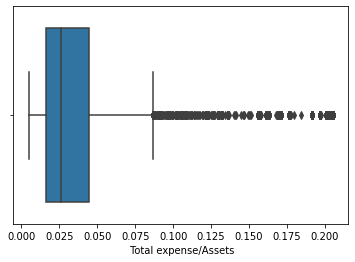

Column name:  Current Asset Turnover Rate 
 Min: 0.0001014549478509 
 Max: 9740000000.0


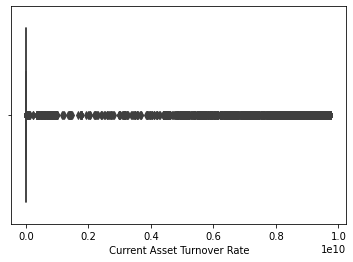

Column name:  Quick Asset Turnover Rate 
 Min: 0.0001010173823413 
 Max: 9790000000.0


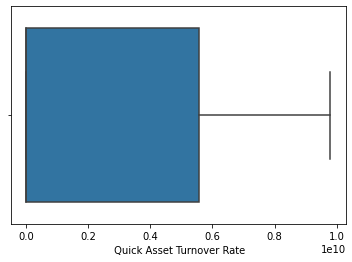

Column name:  Working capitcal Turnover Rate 
 Min: 0.5934762436265484 
 Max: 0.595006797206652


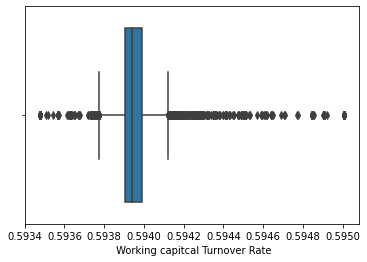

Column name:  Cash Turnover Rate 
 Min: 0.0001044103367222 
 Max: 9470000000.0


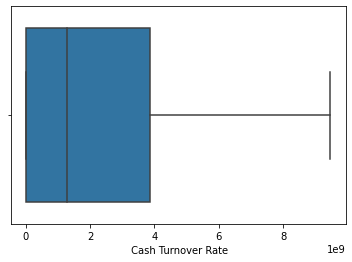

Column name:  Cash Flow to Sales 
 Min: 0.671345490942764 
 Max: 0.6717036171811794


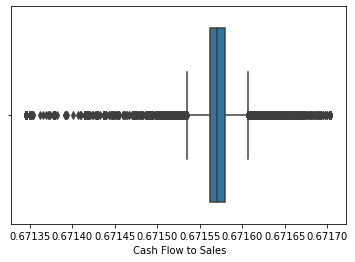

Column name:  Fixed Assets to Assets 
 Min: 0.0033554015885985 
 Max: 0.839608614110646


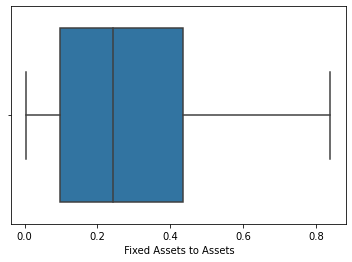

Column name:  Current Liability to Liability 
 Min: 0.22149488967886866 
 Max: 1.0


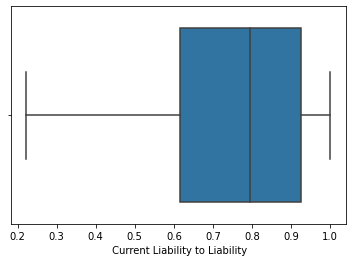

Column name:  Current Liability to Equity 
 Min: 0.294906403882351 
 Max: 0.437794256884166


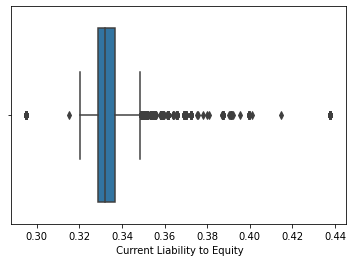

Column name:  Equity to Long-term Liability 
 Min: 0.110933233663468 
 Max: 0.216878231604753


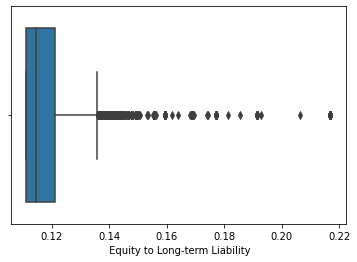

Column name:  Cash Flow to Total Assets 
 Min: 0.5096336704184947 
 Max: 0.7689216389855362


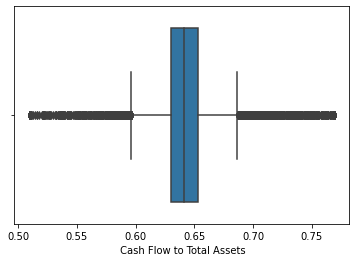

Column name:  Cash Flow to Liability 
 Min: 0.3775159411375453 
 Max: 0.5216100908528245


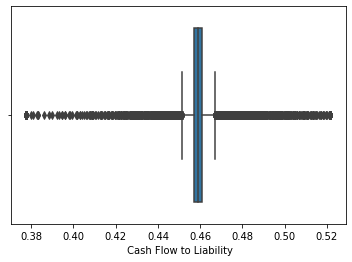

Column name:  CFO to Assets 
 Min: 0.354663247257831 
 Max: 0.7328821740202649


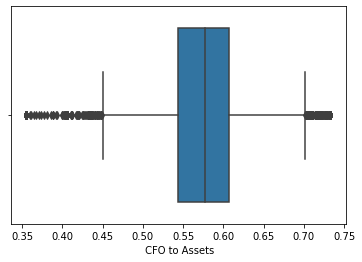

Column name:  Cash Flow to Equity 
 Min: 0.255683866881088 
 Max: 0.33783922941843014


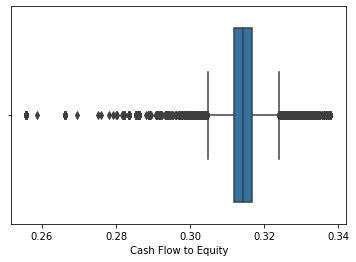

Column name:  Current Liability to Current Assets 
 Min: 0.004087399326991424 
 Max: 0.218206076470393


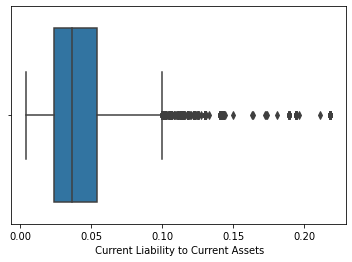

Column name:  Liability-Assets Flag 
 Min: 0 
 Max: 1


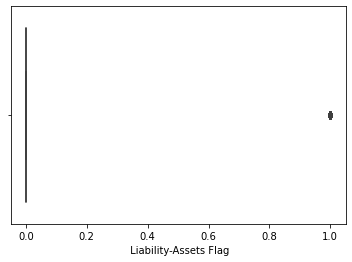

Column name:  Net Income to Total Assets 
 Min: 0.43556895435299503 
 Max: 0.8765754679403305


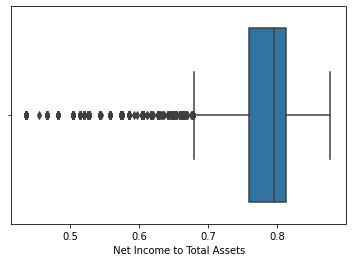

Column name:  Total assets to GNP price 
 Min: 0.000175444777246455 
 Max: 0.387361106962116


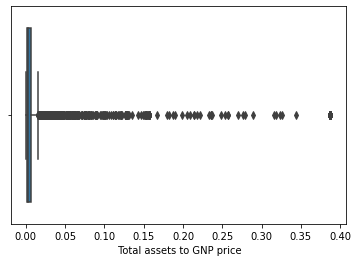

Column name:  No-credit Interval 
 Min: 0.6119112996240671 
 Max: 0.6370766362831259


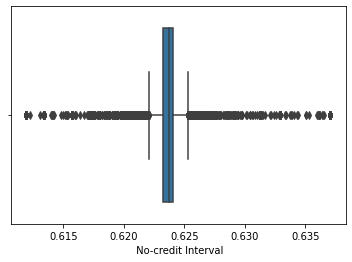

Column name:  Gross Profit to Sales 
 Min: 0.550281705667736 
 Max: 0.6477843118075757


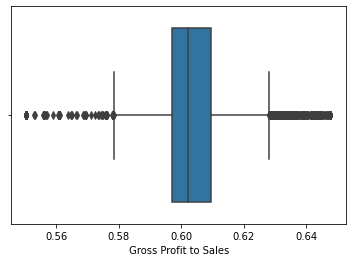

Column name:  Net Income to Stockholder's Equity 
 Min: 0.72688808374371 
 Max: 0.902744139339873


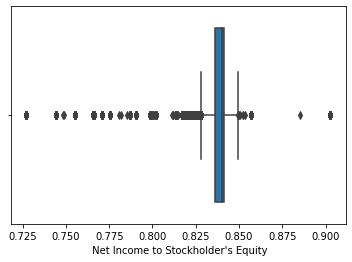

Column name:  Liability to Equity 
 Min: 0.218785274551122 
 Max: 0.38787414714892


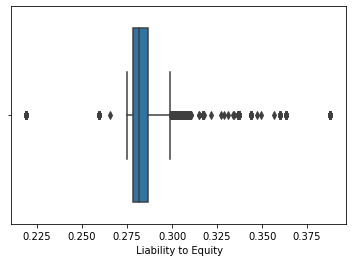

Column name:  Degree of Financial Leverage (DFL) 
 Min: 0.0238317623918237 
 Max: 0.0442796346321322


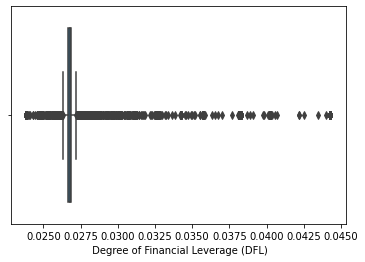

Column name:  Interest Coverage Ratio (Interest expense to EBIT) 
 Min: 0.5521064983136065 
 Max: 0.576472530618164


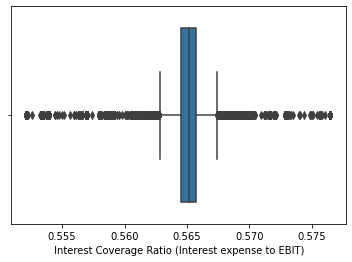

Column name:  Net Income Flag 
 Min: 1 
 Max: 1


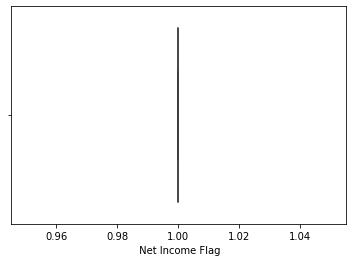

Column name:  Equity to Liability 
 Min: 0.0089497899907776 
 Max: 0.203980771440975


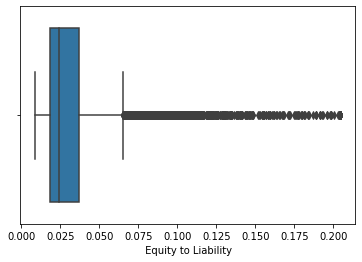

In [66]:
# Looking at min/max of columns
for col in x_train.columns:
  print(f"Column name: {col} \n Min: {x_train[col].min()} \n Max: {x_train[col].max()}")
  sns.boxplot(x=x_train[col])
  plt.show()

Since we will be using decision trees and random forest models, we do not need to standardize the data. Both models are not sensitive to the scale of the features and the splits of the trees are not influenced by other features.

## Modeling

### Decision Tree

In [71]:
# Set up the parameters and distribution
param_dist = {"max_depth": [3, None],
             "max_features": randint(1,9),
             "min_samples_leaf": randint(1,9),
             "criterion": ["gini","entropy"]}
# Set up model
dec_tree = DecisionTreeClassifier()

# Instantiate RandomizedSearchCV
tree_cv = RandomizedSearchCV(dec_tree, param_dist, cv=5)

# Train model
tree_cv.fit(x_train, y_train)

# Predict
tree_pred = tree_cv.predict_proba(x_test)[:,1]
tree_pred1 = tree_cv.predict(x_test)

#### Check Accracy

In [79]:
tree_rocaucscore = roc_auc_score(y_test, tree_pred)
tree_f1score = f1_score(y_test, tree_pred1)
tree_accuracyscore = accuracy_score(y_test, tree_pred1)

print(f'ROC AUC Score: {tree_rocaucscore} \nF-1 Score: {tree_f1score} \nAccuracy Score: {tree_accuracyscore}')

ROC AUC Score: 0.9893533123028392 
F-1 Score: 0.9902562251894622 
Accuracy Score: 0.9897727272727272


The ROC AUC Score computes the area under the Receiver Operating Characteristic Curve (ROC) based off the prediction score. This measures the ability of the distinguish between classes, with the decision tree model having a high performance of .989

The F-1 Score represents the harmonic mean of the precision and recall score, which is on a scale of 0 to 1 with 1 being it reaching the best value. The decision tree model had a high F-1 Score of .99

The Accuracy Score computes subset accuracy, with 1 representing the best performance. Once again, the decision tree model had a high Accuracy Score of .989




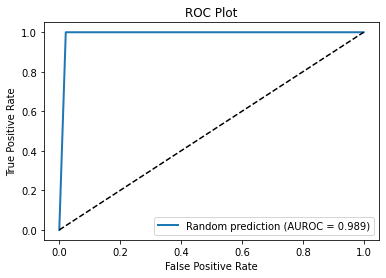

In [81]:
dt_fpr, dt_tpr, _ = roc_curve(y_test, tree_pred)

plt.plot(dt_fpr, dt_tpr, linewidth=2, label='Random prediction (AUROC = %0.3f)' % tree_rocaucscore)
plt.plot([0,1], [0,1], 'k--')

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()